# Transportation problem

**The transportation problem** is one of the problems in optimization with an objective function to optimize the transportation costs of particular items from a number of commodity sources to a number of commodity delivery destinations. For the example, I will use data from excel file and solve it. The excel file's content is data about the sources where the items will be sent, the destination city, and the cost of item shipping and handling between the plants and the cities. Below is the tables on the excel file
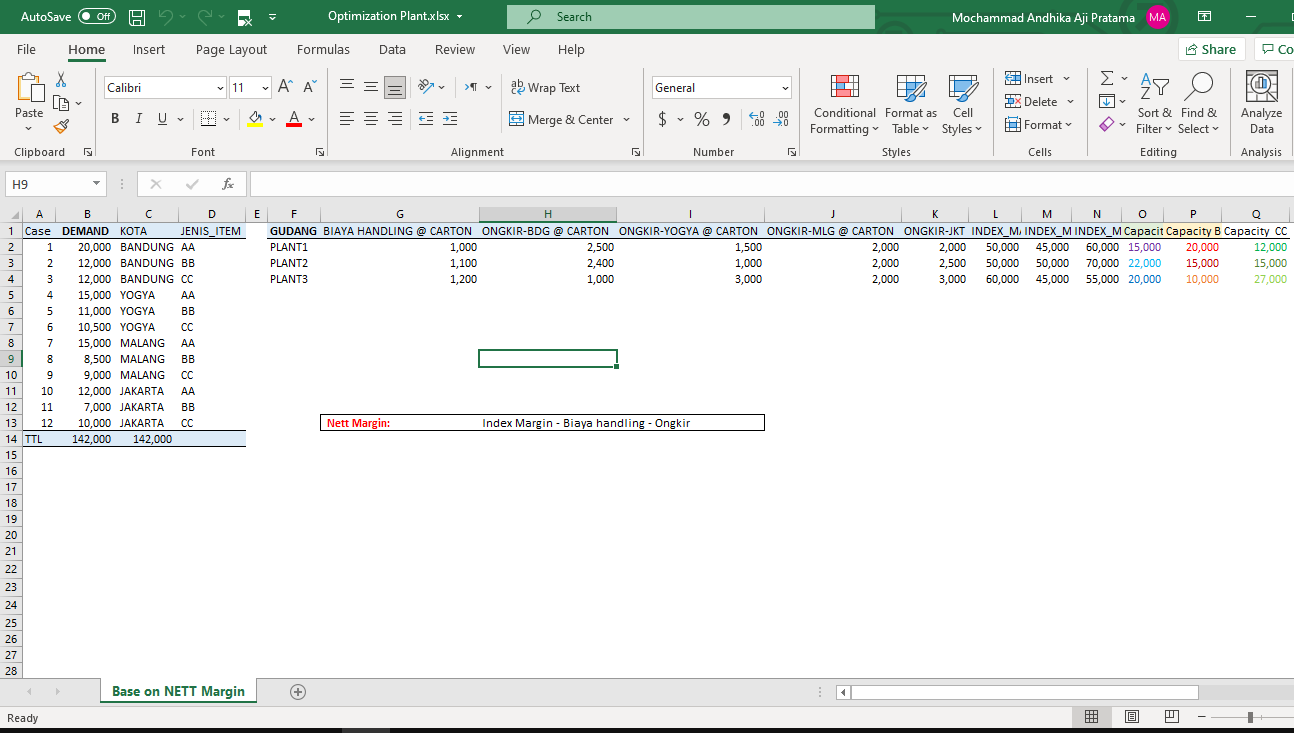

In order to solve the problem, I will divide the problem into several parts:
> 1. Import the data form excel and explore the data
> 2. Modelling the problem
> 3. Solve the problem using linear optimization method

## Import the data

We begin by importing the proper libraries, files and taking a look at what we're dealing with

In [1]:
import numpy as np
import pandas as pd
#!pip install pulp
from pulp import * #pulp is used to solve the problem using linear optimization method for integer variables
df=pd.read_excel('Optimization Plant.xlsx')
df.head(13)

,Case,DEMAND,KOTA,JENIS_ITEM,Unnamed: 4,GUDANG,BIAYA HANDLING @ CARTON,ONGKIR-BDG @ CARTON,ONGKIR-YOGYA @ CARTON,ONGKIR-MLG @ CARTON,ONGKIR-JKT @ CARTON,INDEX_MARGIN AA,INDEX_MARGIN BB,INDEX_MARGIN_CC,Capacity AA,Capacity BB,Capacity CC,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,1,20000.0,BANDUNG,AA,NaN,PLANT1,1000,2500,1500.0,2000.0,2000.0,50000.0,45000.0,60000.0,15000.0,20000.0,12000.0,NaN,NaN,NaN
1,2,12000.0,BANDUNG,BB,NaN,PLANT2,1100,2400,1000.0,2000.0,2500.0,50000.0,50000.0,70000.0,22000.0,15000.0,15000.0,NaN,NaN,NaN
2,3,12000.0,BANDUNG,CC,NaN,PLANT3,1200,1000,3000.0,2000.0,3000.0,60000.0,45000.0,55000.0,20000.0,10000.0,27000.0,NaN,NaN,NaN
3,4,15000.0,YOGYA,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11000.0,YOGYA,BB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,10500.0,YOGYA,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,15000.0,MALANG,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,8500.0,MALANG,BB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,9000.0,MALANG,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,12000.0,JAKARTA,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the table, we can see that the data has:

> 1. 3 types of items that must be sent to 4 cities from 3 different plants
> 2. Each city has certain demand for each item
> 3. Certain fee for shipping from each plant to each city for any item
> 4. There is also handling fee for any item that sent from each plant to any city
> 5. Each plant has capacity limit to sent each type of item to any city
> 6. Each type of item sent from each plant has it's own margin index

**Now, We want to see the supply of each item from each plant and demand of each item from each city**

In [2]:
capacity=df.loc[0:2,["GUDANG","Capacity  AA","Capacity BB","Capacity  CC"]]
capacity.columns=["GUDANG","Capacity_AA","Capacity_BB","Capacity_CC"]
capacity

,GUDANG,Capacity_AA,Capacity_BB,Capacity_CC
0,PLANT1,15000.0,20000.0,12000.0
1,PLANT2,22000.0,15000.0,15000.0
2,PLANT3,20000.0,10000.0,27000.0


In [3]:
capacity.sum()

GUDANG         PLANT1PLANT2PLANT3
Capacity_AA                 57000
Capacity_BB                 45000
Capacity_CC                 54000
dtype: object

In [4]:
demand=df.loc[0:11,['DEMAND','KOTA',"JENIS_ITEM"]]
demand

,DEMAND,KOTA,JENIS_ITEM
0,20000.0,BANDUNG,AA
1,12000.0,BANDUNG,BB
2,12000.0,BANDUNG,CC
3,15000.0,YOGYA,AA
4,11000.0,YOGYA,BB
5,10500.0,YOGYA,CC
6,15000.0,MALANG,AA
7,8500.0,MALANG,BB
8,9000.0,MALANG,CC
9,12000.0,JAKARTA,AA


In [5]:
demand.groupby("JENIS_ITEM")["DEMAND"].sum().reset_index()

,JENIS_ITEM,DEMAND
0,AA,62000.0
1,BB,38500.0
2,CC,41500.0


In this case, the supply or capacity of the plants less than the demands of the city for each item. So there will be cities whose the demand's item are not met.

**Now, Lets see the index margin, transportation cost and handling cost and calculate the netto margin from each item and each destination.**

In [6]:
margin=df.loc[0:2,["GUDANG","INDEX_MARGIN AA","INDEX_MARGIN BB","INDEX_MARGIN_CC"]]
margin.columns=["GUDANG","INDEX_MARGIN_AA","INDEX_MARGIN_BB","INDEX_MARGIN_CC"]
margin

,GUDANG,INDEX_MARGIN_AA,INDEX_MARGIN_BB,INDEX_MARGIN_CC
0,PLANT1,50000.0,45000.0,60000.0
1,PLANT2,50000.0,50000.0,70000.0
2,PLANT3,60000.0,45000.0,55000.0


In [7]:
df["BDG"]=df["BIAYA HANDLING @ CARTON"]+df["ONGKIR-BDG @ CARTON"]
df["YK"]=df["BIAYA HANDLING @ CARTON"]+df["ONGKIR-YOGYA @ CARTON"]
df["MLG"]=df["BIAYA HANDLING @ CARTON"]+df["ONGKIR-MLG @ CARTON"]
df["JKT"]=df["BIAYA HANDLING @ CARTON"]+df["ONGKIR-JKT @ CARTON"]
cost=df.loc[0:2,["GUDANG","BDG","YK","MLG","JKT"]]
cost

,GUDANG,BDG,YK,MLG,JKT
0,PLANT1,3500,2500,3000,3000
1,PLANT2,3500,2100,3100,3600
2,PLANT3,2200,4200,3200,4200


In [8]:
my_list=[]
total=[]
for rows in margin.itertuples():
    my_list+=[rows.INDEX_MARGIN_AA - cost.loc[rows.Index][1], rows.INDEX_MARGIN_BB  - cost.loc[rows.Index][1], 
              rows.INDEX_MARGIN_CC - cost.loc[rows.Index][1]]
    my_list+=[rows.INDEX_MARGIN_AA - cost.loc[rows.Index][2], rows.INDEX_MARGIN_BB  - cost.loc[rows.Index][2], 
              rows.INDEX_MARGIN_CC - cost.loc[rows.Index][2]]
    my_list+=[rows.INDEX_MARGIN_AA - cost.loc[rows.Index][3], rows.INDEX_MARGIN_BB  - cost.loc[rows.Index][3], 
              rows.INDEX_MARGIN_CC - cost.loc[rows.Index][3]]
    my_list+=[rows.INDEX_MARGIN_AA - cost.loc[rows.Index][4], rows.INDEX_MARGIN_BB  - cost.loc[rows.Index][4], 
              rows.INDEX_MARGIN_CC - cost.loc[rows.Index][4]]
    total.append(my_list)
    my_list=[]

In [9]:
Tujuan=[r+"_"+w for r in demand["KOTA"].unique() for w in demand["JENIS_ITEM"].unique()]
Tujuan

['BANDUNG_AA',
 'BANDUNG_BB',
 'BANDUNG_CC',
 'YOGYA_AA',
 'YOGYA_BB',
 'YOGYA_CC',
 'MALANG_AA',
 'MALANG_BB',
 'MALANG_CC',
 'JAKARTA_AA',
 'JAKARTA_BB',
 'JAKARTA_CC']

In [10]:
netto=pd.DataFrame(total,columns=Tujuan)
netto['GUDANG']=capacity["GUDANG"].unique()
netto.set_index("GUDANG", inplace=True)
netto

,BANDUNG_AA,BANDUNG_BB,BANDUNG_CC,YOGYA_AA,YOGYA_BB,YOGYA_CC,MALANG_AA,MALANG_BB,MALANG_CC,JAKARTA_AA,JAKARTA_BB,JAKARTA_CC
GUDANG,,,,,,,,,,,,
PLANT1,46500.0,41500.0,56500.0,47500.0,42500.0,57500.0,47000.0,42000.0,57000.0,47000.0,42000.0,57000.0
PLANT2,46500.0,46500.0,66500.0,47900.0,47900.0,67900.0,46900.0,46900.0,66900.0,46400.0,46400.0,66400.0
PLANT3,57800.0,42800.0,52800.0,55800.0,40800.0,50800.0,56800.0,41800.0,51800.0,55800.0,40800.0,50800.0


## Modelling the problem
The problem will be modeled as linear optimization with integer variables. There are 36 variables, which each variable indicate the amount of one type of item that will be delivered from one plant to one city (there are 3 kinds of items: AA, BB, and CC; 3 plants: Plant1, Plant2, Plant3; and 4 cities: Bandung, Yogya, Malang and Jakarta). The objective is to maximize the Nett Margin (Margin index - Handling fee - Shipping fee) for each item delivered from each plant to each city. The value of $x_i$ must be integer with minimum value 0 because the amount of item is discrete and can not be negative.
The problem first modeled as bellow <br>
<center>$\max\limits_{\bar{x}}c^T \bar{x} \\ \text{s.t. }A\bar{x}\leq\bar{b}$</center>
Where <br> $\bar{x}=(x_1, x_2, \dots, x_{36})$ variable vector, $x_i$ indicates the amount of an item that will be delivered from one plant to one city,
<br> $c^T$ is a objective matrix. $c^T \bar{x}$ indicates total Nett Margin for each item delivered from each plant to each city,
<br>$A$ is constraint matrix, including demand constraint and plant capacity constraint,
<br>$\bar{b}$ is inequality constraint vector. 

**Create the Demand of each item of each city**

In [11]:
q=[Tujuan,list(demand["DEMAND"])]
permintaan={str(q[0][r]) : q[1][r] for r in range(0,len(Tujuan))}
permintaan

{'BANDUNG_AA': 20000.0,
 'BANDUNG_BB': 12000.0,
 'BANDUNG_CC': 12000.0,
 'YOGYA_AA': 15000.0,
 'YOGYA_BB': 11000.0,
 'YOGYA_CC': 10500.0,
 'MALANG_AA': 15000.0,
 'MALANG_BB': 8500.0,
 'MALANG_CC': 9000.0,
 'JAKARTA_AA': 12000.0,
 'JAKARTA_BB': 7000.0,
 'JAKARTA_CC': 10000.0}

**Create the Supply of each item of each plant**

In [12]:
Produk=[r+"_"+w for r in capacity["GUDANG"].unique() for w in demand["JENIS_ITEM"].unique()]
my_list=[]
for rows in capacity.itertuples():
    my_list+=[rows.Capacity_AA, rows.Capacity_BB, rows.Capacity_CC]
s=[Produk,my_list]
penawaran={str(s[0][r]) : s[1][r] for r in range(0,len(Produk))}
penawaran

{'PLANT1_AA': 15000.0,
 'PLANT1_BB': 20000.0,
 'PLANT1_CC': 12000.0,
 'PLANT2_AA': 22000.0,
 'PLANT2_BB': 15000.0,
 'PLANT2_CC': 15000.0,
 'PLANT3_AA': 20000.0,
 'PLANT3_BB': 10000.0,
 'PLANT3_CC': 27000.0}

**Create the parameter of the model**

In [13]:
model = LpProblem("Transportation", LpMaximize)
routes =[(i,j) for i in capacity["GUDANG"].unique() for j in Tujuan]
jumlah_kirim = LpVariable.dicts("The amount of item",(capacity["GUDANG"].unique(),Tujuan),0,cat='Integer')
jumlah_kirim

{'PLANT1': {'BANDUNG_AA': The_amount_of_item_PLANT1_BANDUNG_AA,
  'BANDUNG_BB': The_amount_of_item_PLANT1_BANDUNG_BB,
  'BANDUNG_CC': The_amount_of_item_PLANT1_BANDUNG_CC,
  'YOGYA_AA': The_amount_of_item_PLANT1_YOGYA_AA,
  'YOGYA_BB': The_amount_of_item_PLANT1_YOGYA_BB,
  'YOGYA_CC': The_amount_of_item_PLANT1_YOGYA_CC,
  'MALANG_AA': The_amount_of_item_PLANT1_MALANG_AA,
  'MALANG_BB': The_amount_of_item_PLANT1_MALANG_BB,
  'MALANG_CC': The_amount_of_item_PLANT1_MALANG_CC,
  'JAKARTA_AA': The_amount_of_item_PLANT1_JAKARTA_AA,
  'JAKARTA_BB': The_amount_of_item_PLANT1_JAKARTA_BB,
  'JAKARTA_CC': The_amount_of_item_PLANT1_JAKARTA_CC},
 'PLANT2': {'BANDUNG_AA': The_amount_of_item_PLANT2_BANDUNG_AA,
  'BANDUNG_BB': The_amount_of_item_PLANT2_BANDUNG_BB,
  'BANDUNG_CC': The_amount_of_item_PLANT2_BANDUNG_CC,
  'YOGYA_AA': The_amount_of_item_PLANT2_YOGYA_AA,
  'YOGYA_BB': The_amount_of_item_PLANT2_YOGYA_BB,
  'YOGYA_CC': The_amount_of_item_PLANT2_YOGYA_CC,
  'MALANG_AA': The_amount_of_item_PLA

**Create the objective funtion of the model**

In [14]:
model += lpSum(jumlah_kirim[i][j]*netto.loc[i][j] for (i,j) in routes)

**Create the constraint funtions of the model**

In [15]:
for j in Tujuan:
    model+= lpSum(jumlah_kirim[i][j] for i in capacity["GUDANG"].unique()) <= permintaan[j]
for j in Produk:
    x,y=j.split("_")
    model += lpSum(jumlah_kirim[x][i+"_"+y] for i in demand["KOTA"].unique()) <= penawaran[j]

**Show the model**

In [16]:
model

Transportation:
MAXIMIZE
46500.0*The_amount_of_item_PLANT1_BANDUNG_AA + 41500.0*The_amount_of_item_PLANT1_BANDUNG_BB + 56500.0*The_amount_of_item_PLANT1_BANDUNG_CC + 47000.0*The_amount_of_item_PLANT1_JAKARTA_AA + 42000.0*The_amount_of_item_PLANT1_JAKARTA_BB + 57000.0*The_amount_of_item_PLANT1_JAKARTA_CC + 47000.0*The_amount_of_item_PLANT1_MALANG_AA + 42000.0*The_amount_of_item_PLANT1_MALANG_BB + 57000.0*The_amount_of_item_PLANT1_MALANG_CC + 47500.0*The_amount_of_item_PLANT1_YOGYA_AA + 42500.0*The_amount_of_item_PLANT1_YOGYA_BB + 57500.0*The_amount_of_item_PLANT1_YOGYA_CC + 46500.0*The_amount_of_item_PLANT2_BANDUNG_AA + 46500.0*The_amount_of_item_PLANT2_BANDUNG_BB + 66500.0*The_amount_of_item_PLANT2_BANDUNG_CC + 46400.0*The_amount_of_item_PLANT2_JAKARTA_AA + 46400.0*The_amount_of_item_PLANT2_JAKARTA_BB + 66400.0*The_amount_of_item_PLANT2_JAKARTA_CC + 46900.0*The_amount_of_item_PLANT2_MALANG_AA + 46900.0*The_amount_of_item_PLANT2_MALANG_BB + 66900.0*The_amount_of_item_PLANT2_MALANG_CC + 

**Solve the model**

In [17]:
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


**The result of the problem**

In [18]:
for v in model.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

The_amount_of_item_PLANT1_JAKARTA_AA = 12000.0
The_amount_of_item_PLANT1_JAKARTA_BB = 7000.0
The_amount_of_item_PLANT1_JAKARTA_CC = 10000.0
The_amount_of_item_PLANT1_MALANG_AA = 3000.0
The_amount_of_item_PLANT1_MALANG_BB = 6500.0
The_amount_of_item_PLANT1_MALANG_CC = 2000.0
The_amount_of_item_PLANT2_BANDUNG_BB = 2000.0
The_amount_of_item_PLANT2_MALANG_AA = 7000.0
The_amount_of_item_PLANT2_MALANG_BB = 2000.0
The_amount_of_item_PLANT2_MALANG_CC = 4500.0
The_amount_of_item_PLANT2_YOGYA_AA = 15000.0
The_amount_of_item_PLANT2_YOGYA_BB = 11000.0
The_amount_of_item_PLANT2_YOGYA_CC = 10500.0
The_amount_of_item_PLANT3_BANDUNG_AA = 20000.0
The_amount_of_item_PLANT3_BANDUNG_BB = 10000.0
The_amount_of_item_PLANT3_BANDUNG_CC = 12000.0
The_amount_of_item_PLANT3_MALANG_CC = 2500.0


In [19]:
print("Nett Margin = ", value(model.objective))

Nett Margin =  7077600000.0
